In [ ]:
import matplotlib.pyplot as plt
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

## DRR generation

`DiffDRR` is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

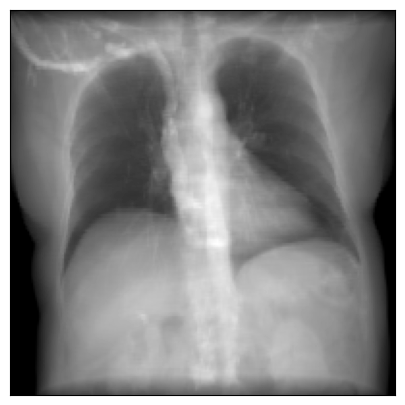

In [ ]:
#| cuda
# Read in the volume and get the anatomic origin
volume, origin, spacing = load_example_ct()

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    volume,  # The CT volume as a numpy array
    origin,  # Location of the voxel [0, 0, 0] in world coordinates
    spacing,  # Voxel dimensions of the CT
    sdr=510.0,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
).to(device)

# Set the camera pose with rotations (yaw, pitch, roll) and translations (x, y, z)
rotations = torch.tensor([[torch.pi / 2, 0.0, -torch.pi / 2]], device=device)
translations = torch.tensor([[350.0, 325.0, -175.0]], device=device)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

We demonstrate the speed of `DiffDRR` by timing repeated DRR synthesis. Timing results are on a single NVIDIA RTX 2080 Ti GPU.

In [ ]:
#| cuda
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

37 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Fast rendering

Since `diffdrr.DRR` is a `torch.nn.Module`, we can kernalize it with `torch.compile`. This improves the rendering time by roughly 2X.

In [ ]:
torch._dynamo.reset()
c_drr = torch.compile(drr)
_ = c_drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
_ = c_drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

In [ ]:
%timeit -n 10 -r 7 c_drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

18.9 ms ± 448 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Sparse rendering

You can also render random sparse subsets of the pixels in a DRR.

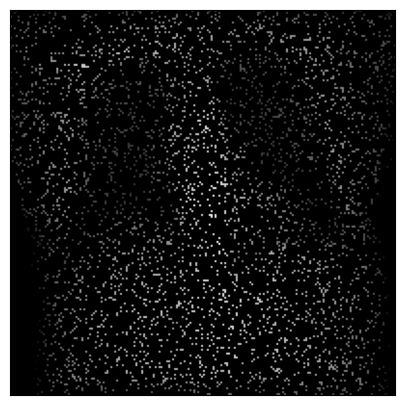

In [ ]:
#| cuda
# Make the DRR with 10% of the pixels
drr = DRR(
    volume,
    origin,
    spacing,
    sdr=510.0,
    height=200,
    delx=2.0,
    p_subsample=0.1,  # Set the proportion of pixels that should be rendered
    reshape=True,  # Map rendered pixels back to their location in true space - useful for plotting, but can be disabled if using MSE as a loss function
).to(device)

# Make the DRR
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

In [ ]:
%timeit drr(rotations, translations, parameterization="euler_angles", convention="ZYX")

6.59 ms ± 21.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Increasing DRR contrast

CT scans are easily segmented using Hounsfield units. We can use this to identify which voxels are air, soft tissue, or bone. By up or downweighting voxels corresponding to bones, we can change the contrast of generated DRRs.

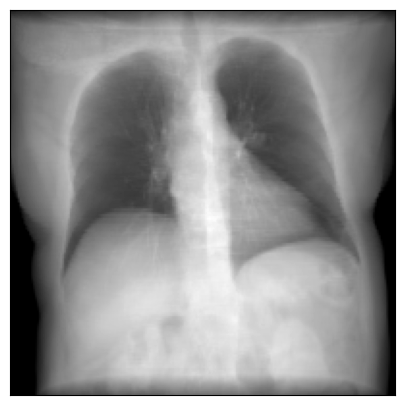

In [ ]:
# Completely downweight bones in CT (i.e., only soft tissue)
drr = DRR(
    volume,
    origin,
    spacing,
    sdr=510.0,
    height=200,
    delx=2.0,
).to(device)

img = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
    bone_attenuation_multiplier=0.0,
)
plot_drr(img, ticks=False)
plt.show()

## Batched DRR synthesis

The tensors for `rotations` are expected to be of the size `[batch_size, c]`, where `c` is the number of components needed to represent the rotation (`3, 4, 6, 10`).
The tensors for `translations` are expected to be of the size `[batch_size, 3]`.

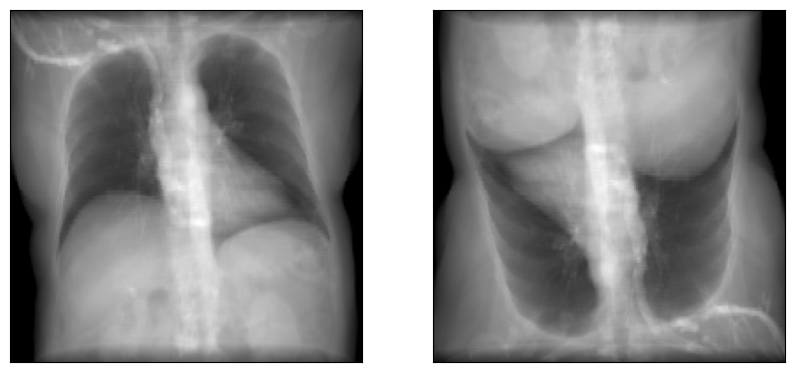

In [ ]:
drr = DRR(
    volume,
    origin,
    spacing,
    sdr=510.0,
    height=200,
    delx=2.0,
).to(device)

rotations = torch.tensor(
    [[torch.pi / 2, 0.0, -torch.pi / 2], [torch.pi / 2, 0.0, torch.pi / 2]],
    device=device,
)
translations = torch.tensor(
    [[350.0, 325.0, -175.0], [350.0, 325.0, -175.0]],
    device=device,
)
img = drr(rotations, translations, parameterization="euler_angles", convention="ZYX")
plot_drr(img, ticks=False)
plt.show()

## Different rendering mode

`DiffDRR` can also render synthetic X-rays using trilinear interpolation instead of Siddon's method. The key argument to pay attention to is `n_points`, which controls how many points are sampled along each ray for interpolation. Higher values make more realistic images, at the cost of higher rendering time.

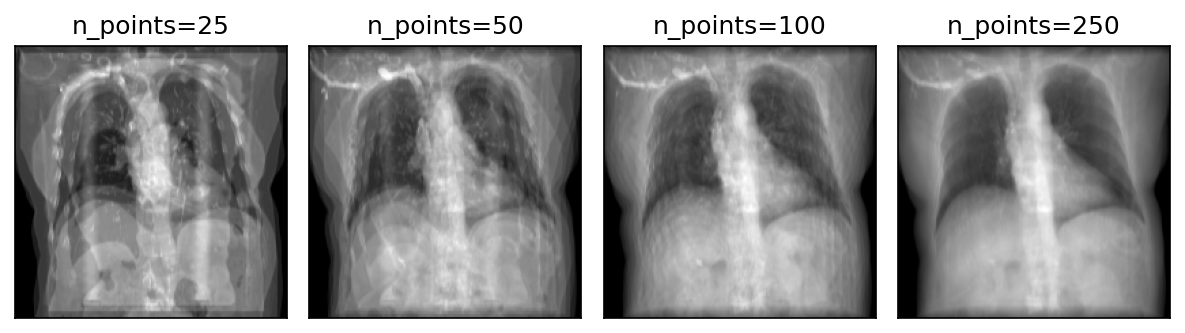

In [ ]:
# Completely downweight bones in CT (i.e., only soft tissue)
drr = DRR(
    volume,
    origin,
    spacing,
    sdr=510.0,
    height=200,
    delx=2.0,
    renderer="trilinear",
).to(device)

rotations = torch.tensor([[torch.pi / 2, 0.0, -torch.pi / 2]], device=device)
translations = torch.tensor([[350.0, 325.0, -175.0]], device=device)

imgs = []
n_points = [25, 50, 100, 250]
for n in n_points:
    img = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZYX",
        n_points=n,
    )
    imgs.append(img)

fig, axs = plt.subplots(1, 4, figsize=(8, 20), dpi=150, tight_layout=True)
img = torch.concat(imgs)
axs = plot_drr(img, ticks=False, axs=axs)
for idx, n in enumerate(n_points):
    axs[idx].set(title=f"n_points={n}")
plt.show()